In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This sets all the initial variables

In [2]:
df = pd.read_parquet('BOQ_data.parquet')
df['PRC'] = df['PRC'].ffill().bfill()
df['ROC'] = df['ROC'].ffill().bfill()
df['EPS'] = df['EPS'].ffill().bfill()
df['roic'] = df['roic'].ffill().bfill()
start = min(df['DATE'])
dates = df['DATE'].unique()
data = {}
dates = sorted(dates)

BIG LOOP

In [26]:
#the buy low sell high strat
#
#
data = {}
AccValues = []
positions = {}
Pnl = []
# perm: num of stocks bought
cash = 10000
def calc_acc_value():
    acc_value = 0
    for key,val in positions.items():
        acc_value += data[key]['price'][-1]*val[0]
    acc_value+=cash
    return acc_value
#looping through dates for backtesting
for date in dates:
    buy = []
    sell = []
    #lists for holding the permnos of the companies that we will buy and sell
    currMonthData = df[df['DATE'] == date]
    #looping through each company in the months data to filter 
    for perm in currMonthData.values:
        name = f'{perm[18]}'
        price = perm[19]
        if data.get(name):
            #updating our own metrics for each company including keeping track of all the different indicators we use for signals
            curr = data[name]
            curr['price'].append(price)
            prc_chg = price/curr['price'][-2]-1
            curr['mth_prc_chg'] = prc_chg
            sma5=0
            #caluculate 5 month and 10 month moving average
            if len(curr['price'])>=5:
                sma5 = (sum(curr['price'][-5:]))/5
            #adding to buy or sell if hitting certain signals
            if price<sma5:
                buy.append(name)
            elif price>sma5:
                sell.append(name)
        else:
            data[name] = {'price':[price]}
    #stop loss is first
    for key,val in positions.items():
        price = data[key]['price'][-1]
        if len(val)>2:
            if ((sum(val[1:])/len(val[1:]))/price-1)<-.005:
                cash+=price*val[0]
                positions[key] = [0]
    #sell all in sell list
    for per in sell:
        price = data[per]['price'][-1]
        if positions.get(per):
            if positions[per][0]>0:
                cash += price*positions[per][0]
                positions[per] = [0]
    #buy all in buy list
    for per in buy:
        price = data[per]['price'][-1]
        if cash > price :
            if positions.get(per):
                positions[per][0] += 1
                positions[per].append(price)
                cash-= price
            else:
                positions[per] = [1,price]
                cash -= price
    # gets the current value of all the positions after each iteration on the dates
    acc_val = calc_acc_value()
    AccValues.append(acc_val)
    Pnl.append(acc_val-10000)

In [ ]:
#the roic and earnings yield strat
#
#
data = {}
AccValues = []
positions = {}
Pnl = []
# perm: num of stocks bought
cash = 10000
def calc_acc_value():
    acc_value = 0
    for key,val in positions.items():
        acc_value += data[key]['price'][-1]*val[0]
    acc_value+=cash
    return acc_value
#looping through dates for backtesting
for date in dates:
    buy = []
    sell = []
    #lists for holding the permnos of the companies that we will buy and sell
    currMonthData = df[df['DATE'] == date]
    #looping through each company in the months data to filter 
    for perm in currMonthData.values:
        name = f'{perm[18]}'
        price = perm[19]
        roic = perm[73]
        roc = perm[22]
        eps = perm[11]
        eyield = eps/price * 100
        if data.get(name):
            #updating our own metrics for each company including keeping track of all the different indicators we use for signals
            curr = data[name]
            curr['price'].append(price)
            curr['roic'] = roic
            curr['eyield'] = eyield
            prc_chg = price/curr['price'][-2]-1
            curr['mth_prc_chg'] = prc_chg
            sma5=0
            #caluculate 5 month and 10 month moving average
            if len(curr['price'])>=5:
                sma5 = (sum(curr['price'][-5:]))/5
            #adding to buy or sell if hitting certain signals
            if price<sma5:
                buy.append(name)
            elif price>sma5:
                sell.append(name)
        else:
            data[name] = {'price':[price],'roic':roic,'eyield':eyield}
    #stop loss is first
    for key,val in positions.items():
        price = data[key]['price'][-1]
        if len(val)>2:
            if ((sum(val[1:])/len(val[1:]))/price-1)<-.005:
                cash+=price*val[0]
                positions[key] = [0]
    #sell all in sell list
    for per in sell:
        price = data[per]['price'][-1]
        if positions.get(per):
            if positions[per][0]>0:
                cash += price*positions[per][0]
                positions[per] = [0]
    #buy all in buy list
    for per in buy:
        price = data[per]['price'][-1]
        if cash > price :
            if positions.get(per):
                positions[per][0] += 1
                positions[per].append(price)
                cash-= price
            else:
                positions[per] = [1,price]
                cash -= price
    # gets the current value of all the positions after each iteration on the dates
    acc_val = calc_acc_value()
    AccValues.append(acc_val)
    Pnl.append(acc_val-10000)

get the column index for a identifier

In [27]:
#calculate sharpe ratio
def sharpe(lis):
    returns = np.diff(lis) / lis[:-1]
    mean_return = np.mean(returns)
    std_dev = np.std(returns)
    sharpe_ratio = (mean_return - 0.03 / 12) / std_dev
    return sharpe_ratio
sharpe(AccValues)

0.04413881843683544

In [5]:
#get column index for indicator
cols = df.columns.values
inp = input(f'{cols}   which name?')
def get_index(name):
    count = 0
    it = iter(cols)
    while name!=next(it):
        count+=1
        if count == 85:
            count+=1
            break
    return count
print(get_index(inp))

11


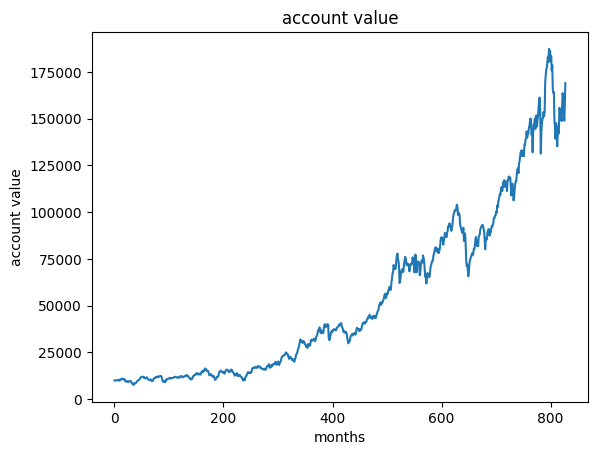

23.040226957833234

In [28]:
#plot pnl
plt.plot(np.arange(len(AccValues)),AccValues)
plt.xlabel('months')
plt.ylabel('account value')
plt.title('account value')
plt.show()
(AccValues[-1]/10000 -1)*100/len(AccValues)*12

0         -0.560000
1         -0.560000
2         -0.560000
3         -0.560000
4         -0.560000
             ...   
3568650    0.132384
3568651    0.132384
3568652    0.132384
3568653    0.132384
3568654    0.132384
Name: roic, Length: 3534205, dtype: float64